# 🛡️ Sentinel Phase 02: The Trinity (3-Input System)

In this advanced phase, we upgrade the Sentinel to a **3-dimensional** decision engine. We are adding **Distance** to the equation to detect complex fraud scenarios like "Impossible Travel".

**The Three Pillars of Detection:**
* **Amount ($):** How much money is moving?
* **Frequency (Count):** How fast are the transactions?
* **Distance (km):** How far is the user from home?

In [23]:
!pip install scikit-fuzzy -q
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# --- 1. Define Inputs & Output ---

# Amount: $0 - $5000
amount = ctrl.Antecedent(np.arange(0, 5001, 1), 'amount')

# Frequency: 0 - 50 tx/hr
freq = ctrl.Antecedent(np.arange(0, 51, 1), 'frequency')

# Distance: 0 - 2000 km
dist = ctrl.Antecedent(np.arange(0, 2001, 1), 'distance')

# Risk Score: 0% - 100%
risk = ctrl.Consequent(np.arange(0, 101, 1), 'risk')

### 📊 Defining Sensitivity (5-Levels)

To make the system smarter, we use a **5-Level Scale** instead of simple Low/High logic. This gives us maximum precision.

**Levels:** `Very Low` → `Low` → `Medium` → `High` → `Very High`

In [24]:
# --- 2. Membership Functions ---

# Amount ($)
amount['very_low']  = fuzz.trapmf(amount.universe, [0, 0, 50, 200])
amount['low']       = fuzz.trimf(amount.universe, [150, 400, 800])
amount['medium']    = fuzz.trimf(amount.universe, [600, 1200, 2500])
amount['high']      = fuzz.trimf(amount.universe, [2000, 3500, 4500])
amount['very_high'] = fuzz.trapmf(amount.universe, [4000, 4800, 5000, 5000])

# Frequency (Count)
freq['very_low']  = fuzz.trapmf(freq.universe, [0, 0, 2, 5])
freq['low']       = fuzz.trimf(freq.universe, [3, 8, 15])
freq['medium']    = fuzz.trimf(freq.universe, [12, 20, 30])
freq['high']      = fuzz.trimf(freq.universe, [25, 35, 45])
freq['very_high'] = fuzz.trapmf(freq.universe, [40, 45, 50, 50])

# Distance (km)
dist['very_close'] = fuzz.trapmf(dist.universe, [0, 0, 10, 50])
dist['close']      = fuzz.trimf(dist.universe, [30, 150, 400])
dist['medium']     = fuzz.trimf(dist.universe, [300, 700, 1200])
dist['far']        = fuzz.trimf(dist.universe, [1000, 1500, 1800])
dist['very_far']   = fuzz.trapmf(dist.universe, [1600, 1900, 2000, 2000])

# Risk Output (%)
risk['safe']       = fuzz.trapmf(risk.universe, [0, 0, 20, 40])
risk['suspicious'] = fuzz.trimf(risk.universe, [30, 50, 70])
risk['dangerous']  = fuzz.trapmf(risk.universe, [60, 80, 100, 100])

### 🧠 The Brain: Logic Rules

We define **10 Strategic Rules** to cover every possible scenario.

* **Green Zone:** Normal daily behavior.
* **Yellow Zone:** Unusual activity, needs verification.
* **Red Zone:** Clear fraud indicators (e.g., Bot Attacks, Impossible Travel).

In [25]:
# --- 3. Define Rules (Revised & Gap-Free) ---

# Güvenli Durumlar (Safe)
r1 = ctrl.Rule(amount['very_low'] | amount['low'], risk['safe'])
r2 = ctrl.Rule(dist['very_close'] & freq['low'], risk['safe'])
r3 = ctrl.Rule(dist['close'] & freq['medium'], risk['safe'])

# Şüpheli Durumlar (Suspicious)
# Tutar VEYA Mesafe 'Medium' ise şüphelen
r4 = ctrl.Rule(amount['medium'] | dist['medium'], risk['suspicious'])
# Yüksek tutar ama evde (Home) -> Şüpheli
r5 = ctrl.Rule(amount['high'] & dist['very_close'], risk['suspicious'])

# Tehlikeli Durumlar (Dangerous)
r6 = ctrl.Rule(amount['high'] & dist['far'], risk['dangerous'])
r7 = ctrl.Rule(freq['high'], risk['dangerous'])
r8 = ctrl.Rule(amount['very_high'], risk['dangerous'])

# Kesin Dolandırıcılık (Fraud)
r9 = ctrl.Rule(freq['very_high'], risk['dangerous']) # Bot
r10 = ctrl.Rule(dist['very_far'], risk['dangerous']) # Impossible Travel

# Sistemi Kur (Tüm kuralları ekle)
sentinel_ctrl = ctrl.ControlSystem([r1, r2, r3, r4, r5, r6, r7, r8, r9, r10])
sentinel = ctrl.ControlSystemSimulation(sentinel_ctrl)
print("✅ Kurallar güncellendi ve kapsayıcı hale getirildi.")

✅ Kurallar güncellendi ve kapsayıcı hale getirildi.


### 🚀 Simulation: Test Run

Let's test the Sentinel with a real-world fraud scenario.

* **Scenario:** High spending ($4800) at a very far location (1900 km).
* **Expectation:** The system should flag this as **High Risk**.

In [26]:
# --- 4. Run Simulation ---

# Scenario Inputs
sentinel.input['amount'] = 4800
sentinel.input['frequency'] = 30
sentinel.input['distance'] = 1900

# Calculate
sentinel.compute()
risk_score = sentinel.output['risk']

print(f"🛑 RISK SCORE: {risk_score:.2f}%")

🛑 RISK SCORE: 84.44%


### 👁️ Visualizing the Logic

Here we inspect the "Fuzzy Sets" to see how the system categorizes our inputs.

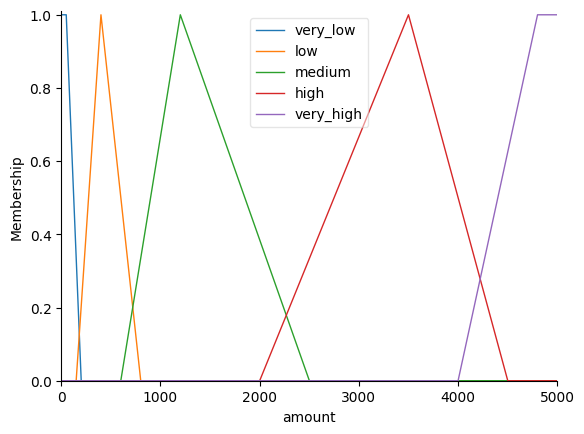

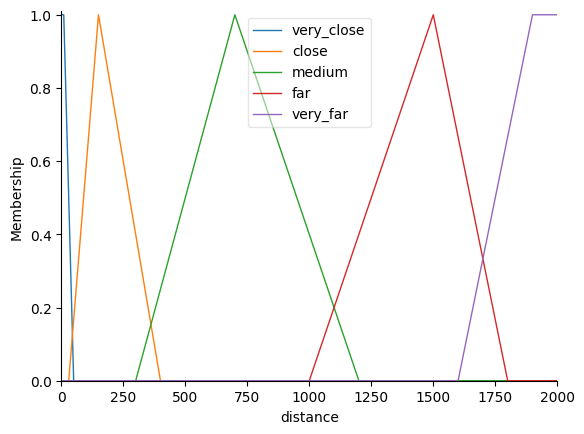

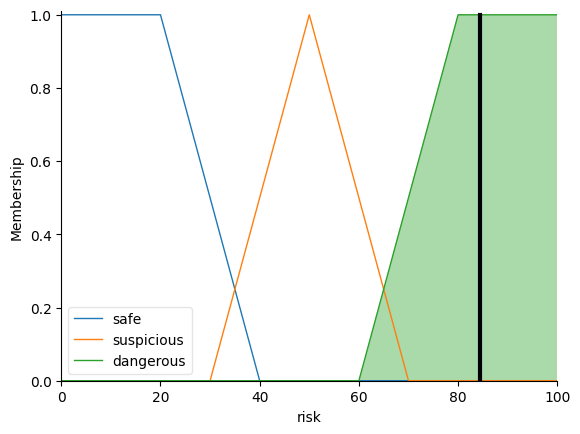

In [27]:
# --- 5. View Graphs ---

# Input: Amount
amount.view()

# Input: Distance
dist.view()

# Output: Risk
risk.view(sim=sentinel)

plt.show()

### 🏔️ The Risk Landscape (3D Surface)

This 3D surface shows the **Decision Boundary**. It reveals how Risk increases as Amount and Distance rise together.

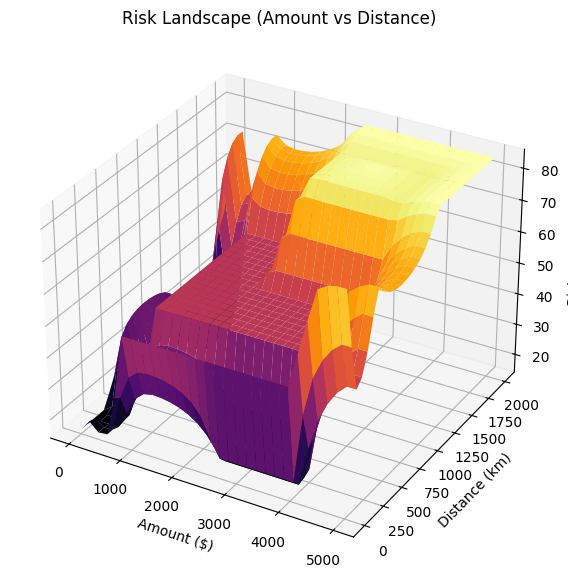

In [28]:
from mpl_toolkits.mplot3d import Axes3D

# 1. Get the correct label name dynamically to avoid KeyError
risk_label = risk.label

# 2. Generate Grid
x_vals = np.linspace(0, 5000, 30)
y_vals = np.linspace(0, 2000, 30)
X, Y = np.meshgrid(x_vals, y_vals)
Z = np.zeros_like(X)

# 3. Compute Risk Grid
# We fix Frequency at 20 (Medium Activity)
sentinel.input['frequency'] = 20

for i in range(30):
    for j in range(30):
        sentinel.input['amount'] = X[i, j]
        sentinel.input['distance'] = Y[i, j]

        sentinel.compute()
        # Use dynamic label
        Z[i, j] = sentinel.output[risk_label]

# 4. Plot 3D Surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='inferno')

ax.set_xlabel('Amount ($)')
ax.set_ylabel('Distance (km)')
ax.set_zlabel('Risk Score (%)')
ax.set_title('Risk Landscape (Amount vs Distance)')
plt.show()

### 🕹️ Interactive 3D Model

Static charts are good, but interactive ones are better. Use this graph to explore the "Peaks of Fraud".

* **Rotate** the cube to see hidden angles.
* **Hover** to see the exact risk score.

In [29]:
import plotly.graph_objects as go

# We use the same Z data from Step 6
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, colorscale='Viridis')])

fig.update_layout(
    title='Interactive Risk Landscape',
    scene = dict(
        xaxis_title='Amount ($)',
        yaxis_title='Distance (km)',
        zaxis_title='Risk Score (%)'
    ),
    width=800, height=600
)

fig.show()

# 🏁 Final Result: The Sentinel is Live

The mathematical model is now ready for the real world. We map the calculated **Risk Score** to concrete actions.

**Security Protocols:**
* **🟢 0% - 40% (Safe):** Transaction Approved.
* **🟡 40% - 70% (Suspicious):** Send SMS Verification (OTP).
* **🔴 70% - 100% (Fraud):** **BLOCK** Transaction immediately.

In [30]:
def check_risk(amount_val, freq_val, dist_val):
    # 1. Pass inputs to Sentinel
    sentinel.input['amount'] = amount_val
    sentinel.input['frequency'] = freq_val
    sentinel.input['distance'] = dist_val

    # 2. Compute
    sentinel.compute()
    risk_label = risk.label # Get dynamic label
    score = sentinel.output[risk_label]

    # 3. Decision Logic
    if score < 40:
        status = "🟢 APPROVED"
    elif score < 70:
        status = "🟡 VERIFY (SMS)"
    else:
        status = "🔴 BLOCKED"

    # 4. Print Log
    print(f"Tx: ${amount_val} | {freq_val}/hr | {dist_val}km  -->  Risk: {score:.1f}%  [{status}]")

# --- LIVE TEST SCENARIOS ---
print("--- SENTINEL SECURITY LOG ---")
check_risk(120, 5, 10)       # Scenario 1: Coffee near home
check_risk(4500, 30, 1800)   # Scenario 2: High Amount + Far + High Freq (FRAUD)
check_risk(200, 45, 20)      # Scenario 3: Bot Attack (High Freq)
check_risk(3000, 5, 1500)    # Scenario 4: Holiday Shopping (Verify)

--- SENTINEL SECURITY LOG ---
Tx: $120 | 5/hr | 10km  -->  Risk: 17.5%  [🟢 APPROVED]
Tx: $4500 | 30/hr | 1800km  -->  Risk: 83.1%  [🔴 BLOCKED]
Tx: $200 | 45/hr | 20km  -->  Risk: 71.2%  [🔴 BLOCKED]
Tx: $3000 | 5/hr | 1500km  -->  Risk: 83.1%  [🔴 BLOCKED]
